# Semantic Image Segmentation
Guilherme Milan Santos  
Romeu Bertho Junior


## Overview
The aim of this project is to investigate the implementation and the applications of semantic segmentation via deep learning models. We will attempt to build and train a fully convolutional neural network (FCN) from scratch, as well as compare it to pretrained models and other CNN architectures. Finally, we will explore different applications, such as medical image segmentation and autonomous driving.  



<img src="press/cat_segmentation.png" align="center" width="600" height="600">

<img src="press/pt.jpg" align="center" width="300" height="300">

The FCN-based architectures were deemed the most reasonable for the proposed deadline, both due to the relative ease of comprehension and implementation, as well to the computational power required in comparison with more recent models.

FCN-based models have been developed on top of several different architectures, notably AlexNet and VGG. For this work, the chosen approach was to take a pretrained Alexnet, and gradually add the layers that turn it into a FCN.

More modern implementations are built on top of the pretrained layers of a VGG network. This will be attempted as long as there is enough time left after the experiments with FCN-Alexnet have been performed.

Implementation was done on PyTorch using CUDA.

## Applications

Semantic image segmentation is the process of mapping and classifying the natural
world for many critical applications such as especially autonomous driving, robotic
navigation, localization, and medical images. It is an important technique for the scene
understanding because each pixel is labeled as belonging to a given semantic class. 

<img src="press/1-s2.0-S0924271619300383-gr7_lrg.jpg" align="left" width="300" height="1000">
<img src="press/68747470733a2f2f692e6962622e636f2f4e4e6b335679662f706f6c79702e706e67.png" align="right" width="200" height="200">
<img src="press/68747470733a2f2f692e6962622e636f2f4733785a5636532f7374726565742d7365676d656e742e706e67.png" align="center" width="200" height="200">

## Transfer Learning

A pretrained Alexnet has been successfully loaded, its layers frozen and fine tuned for classification on a smaller dataset with an accuracy rating of 85%, which is about the reported accuracy value for the Alexnet. Most recently, the classification layers were removed to make way to the first deconvolution layers. Some of the legacy code in which the classification dataset was loaded is still present and undergoing modification. 

<img src="press/1_f2_PnaPgA9iC5bpQaTroRw.png" align="center" width="800" height="800">

## Preprocessing

Preprocessing task was a good challenge for us, at first glance handling MS COCO seems very easy as ploting a beauty ground truty, the problems came when we started understanding deeper how MS COCO API and our network works.
MS Coco train dataset from 2014 has 82783 images, 13gb size and provides it's segmentation masks in a compressed, encoded format. COCO provides up to 80 classes labeled from 1 to 90.  
Several preprocessing strategies were attempted. Initially, focus was set on trying to maintain the maximum amount of information from the original dataset as possible while trying to minimize the computational effort required to load the minibatches during training.

In [59]:
from pycocotools.coco import COCO
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from coco_dataset import CocoDataset

In [20]:
# initialize COCO api to handle instance annotations
dataType='train2014'
annFile='downloads/dataset/annotations/instances_{}.json'.format(dataType)
coco=COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=27.60s)
creating index...
index created!


In [82]:
imgIds = np.array(imgIds)
img = coco.loadImgs(imgIds[0:10])
I = [io.imread(im['coco_url']) for im in img[0:10]]
# Returns the segmentation mask for a specified image index
def load_ground_truth(img):
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    seg_imageNch = np.zeros((90 + 1, img['height'],img['width'])).astype(np.uint8)
    seg_imageGray = np.zeros((img['height'],img['width'])).astype(np.uint8)
    seg_imageRGB=np.zeros((img['height'],img['width'],3)).astype(np.uint8)
    for i in range(len(anns)):
        seg_image = coco.annToMask(anns[i])
        h,w = seg_image.shape 
#                 print(np.unique(seg_image))
        seg_imageNch[anns[i]['category_id'], :h, :w] = \
            seg_imageNch[anns[i]['category_id'], :h, :w] | seg_image[:, :]
        seg_image = (seg_image - (seg_image & seg_imageGray[:h, :w]))
#                 print('LGT unique 0: ',i,np.unique(seg_imageGray))
        imgRGB = np.zeros((seg_image.shape[0],seg_image.shape[1],3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        imgRGB[:,:,0]=((seg_imageGray|seg_image)==1)*color_mask[0]
        imgRGB[:,:,1]=((seg_imageGray|seg_image)==1)*color_mask[1]
        imgRGB[:,:,2]=((seg_imageGray|seg_image)==1)*color_mask[2]
        seg_imageRGB=seg_imageRGB+imgRGB
        seg_imageGray[:h, :w] = (seg_imageGray[:h, :w] | ((seg_imageGray[:h, :w] | seg_image) == 1)* anns[i]['category_id'])
#                 print('LGT unique 1: ',i,np.unique(seg_imageGray))
    seg_imageNch[0, :, :] = seg_imageGray.astype(np.uint8)
    return seg_imageRGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


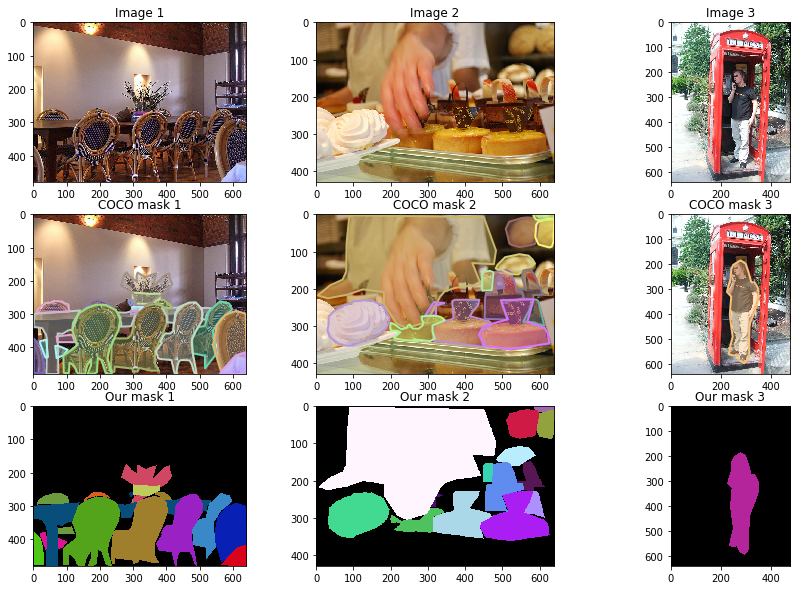

In [86]:
plt.figure(figsize=(15,10))
plt.subplot(331); plt.imshow(I[0]); plt.title("Image 1");
plt.subplot(332); plt.imshow(I[1]); plt.title("Image 2");
plt.subplot(333); plt.imshow(I[2]); plt.title("Image 3");
plt.subplot(334); plt.imshow(I[0]); plt.title("COCO mask 1"); annsIds = coco.getAnnIds(imgIds=img[0]['id'], iscrowd=None); anns = coco.loadAnns(annsIds); coco.showAnns(anns)
plt.subplot(335); plt.imshow(I[1]); plt.title("COCO mask 2"); annsIds = coco.getAnnIds(imgIds=img[1]['id'], iscrowd=None); anns = coco.loadAnns(annsIds); coco.showAnns(anns)
plt.subplot(336); plt.imshow(I[2]); plt.title("COCO mask 3"); annsIds = coco.getAnnIds(imgIds=img[2]['id'], iscrowd=None); anns = coco.loadAnns(annsIds); coco.showAnns(anns)
plt.subplot(337); plt.imshow(load_ground_truth(img[0])); plt.title("Our mask 1");
plt.subplot(338); plt.imshow(load_ground_truth(img[1])); plt.title("Our mask 2");
plt.subplot(339); plt.imshow(load_ground_truth(img[2])); plt.title("Our mask 3");

### MS COCO files
Filename | Description | Size
--- | --- | ---
[train2014.zip](http://images.cocodataset.org/zips/train2014.zip) | COCO 2014 train images (83K images) | 13 GB
[val2014.zip](http://images.cocodataset.org/zips/val2014.zip) | COCO 2014 val images (41K images) | 6 GB
[test2014.zip](http://images.cocodataset.org/zips/test2014.zip) | COCO 2014 test images (41K images) | 6 GB
[annotations_trainval2014.zip](http://images.cocodataset.org/annotations/annotations_trainval2014.zip) | COCO annotations on COCO 2014 train and val, including segmentation labels and image info | 241 MB
[image_info_test2014.zip](http://images.cocodataset.org/annotations/image_info_test2014.zip) | COCO annotations on COCO 2014 test, including segmentation labels and image info | 1 MB

To use this dataset you will need to download the images (13+0.3GB) and annotations of the trainval sets.
Segmentation masks is compressed in a json file, each object are listed in a separate channel, although COCO API provides a easy way to view segmentation masks, you can't use or save it in the same dimensions like original image. 

### Label Hierarchy
This figure shows the label hierarchy of COCO-Stuff including all stuff and thing classes:

<img src="press/cocostuff-labelhierarchy.png" align="center" width="800" height="800">


### First Approach

The first attempt involved generating one-channel images, in which each pixel had the value corresponding to its class id as annotated in the ground truth. During training, each minibatch would expand the images into 90-channel images, 90 being the total number of classes provided by Coco. After expansion, each pixel on each channel would contain a binary value, with 1 meaning the pixel on location (x,y) and channel k belongs to class k, and a 0 meaning it doesn't. Only a single channel would contain a value of 1 for a pixel, while all the others would show 0.

### Second Approach

The second approach consisted of generating plain text files for each image, which would contain a matrix for every object category featured in the respective image. Those matrixes would represent the channels of the 90-channel image used during training, in which a value of 1 at pixel (x,y) and matrix k would mean that that pixel belongs to class k. Matrixes which had only null values were not stored and their absence would imply a null matrix. Metadata contained in the files would inform which class each matrix belongs to.

### Third Approach
Through experimentation, those approaches were deemed too time-consuming to perform during training, what if we try to load json and extract everything we need in an optimized manner during training and rent an AWS server? This can make training viable as we have limited hardware. Indeed, this was the best idea as we dont need to keep reading a lot of data from hard drive. 

## Results


## What's next
- [ ] Finish training on AWS servers
- [ ] Train on different FCNs
- [ ] Compare with preliminary results

## References
[1]COCO - Common Objects in Context. Available on http://cocodataset.org/

[2]A benchmark for Endoluminal Scene Segmentation of Colonoscopy Images. Available on https://arxiv.org/pdf/1612.00799.pdf

[3]Motion-based Segmentation and Recognition Dataset. Available on mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

[4]Fully Convolutional Networks for Semantic Segmentation. Available on https://arxiv.org/abs/1411.4038

[5]Torchvision.models documentation. Avaible on https://pytorch.org/docs/stable/torchvision/models.html

[6]Segmentation and Recognition Using Structure from Motion Point Clouds, ECCV 2008
Brostow, Shotton, Fauqueur, Cipolla

[7]Semantic Object Classes in Video: A High-Definition Ground Truth Database
Brostow, Fauqueur, Cipolla 